In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# Create a toy problem on a sphere
Here we create a toy problem where we have points on a 2-sphere, corresponding to our latent representations z's. If our first contrastive learning (CL) step works well, we should have clusters that are very well separated in the 32 dimensional latent space. Hence I set the "cluster_spread" below to be small to reflect that ideal situation.

Note that if our first CL step doesn't work well, we will not have nicely clustered z representations. This will make the hopfield step much harder, with the most obvious symptom being failing to learn beta.

In [2]:
# Set up a sphere in R^3
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 50)
theta, phi = np.meshgrid(theta, phi)
r = 1

# Convert to Cartesian coordinates
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

In [3]:
def plot_sphere(x, y, z, x_points, y_points, z_points, title):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)
    ax.scatter(x_points, y_points, z_points, c='red', s=50)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.set_box_aspect((1, 1, 1))
    plt.show()

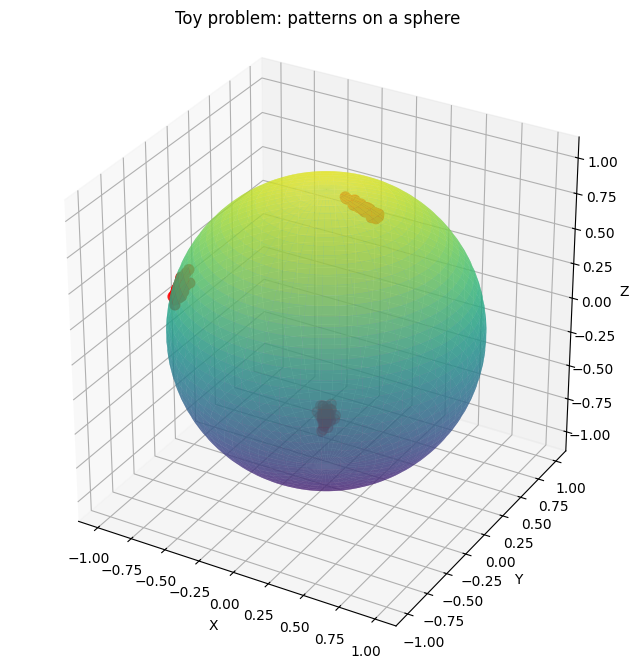

In [4]:
def generate_sphere_clusters(r, num_clusters, points_per_cluster, cluster_spread):
    """
    Generate clustered points on a sphere.
    
    Args:
        r: sphere radius
        num_clusters: number of clusters
        points_per_cluster: points in each cluster
        cluster_spread: controls tightness (smaller = tighter clusters)
    """
    all_x, all_y, all_z = [], [], []
    
    # Generate cluster centers uniformly on sphere
    center_theta = np.random.uniform(0, 2 * np.pi, num_clusters)
    center_phi = np.random.uniform(0, np.pi, num_clusters)
    
    for i in range(num_clusters):
        # Sample points around each center using von Mises-Fisher distribution
        # (or simple Gaussian perturbation for simplicity)
        theta_offset = np.random.normal(0, cluster_spread, points_per_cluster)
        phi_offset = np.random.normal(0, cluster_spread, points_per_cluster)
        
        theta = center_theta[i] + theta_offset
        phi = np.clip(center_phi[i] + phi_offset, 0, np.pi)  # Keep phi in valid range
        
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        
        all_x.extend(x)
        all_y.extend(y)
        all_z.extend(z)
    
    return np.array(all_x), np.array(all_y), np.array(all_z)

num_clusters = 3
points_per_cluster = 60
cluster_spread = 0.05
x_points, y_points, z_points = generate_sphere_clusters(r, num_clusters, points_per_cluster, cluster_spread)
plot_sphere(x, y, z, x_points, y_points, z_points, 'Toy problem: patterns on a sphere')

patterns = np.vstack([x_points, y_points, z_points]).T

# CL loss vs beta
I am proposing to learn beta as follows: 
At each beta learning step:

0. (optional, not done here) Randomly select a large and diverse subset of patterns if the pattern matrix U would be too large for efficient compute.
1. Randomly sub-sample a batch from the set of patterns.
2. Make a noisy copy z' of each sample z in the batch
3. Apply hopfield update once to each pair of z and z', sending them to u and u' respectively (btw u and u' are not the fixed points)
4. Compute CL loss using positive pairs (u, u')

In the following we will see that the CL loss computed this way usually has a clear minimum, indicating a learnable optimal beta.

In [5]:
# Import hopfield update 
from models.cmhn import cmhn
mhn = cmhn(max_iter = 1)  # use one update when learning beta 

In [6]:
def make_noisy_patterns(sample_patterns, noise_level):  # a way of making noisy pattern for this toy problem. We use drop out in the real problem.
    noisy_patterns = []
    for i in range(sample_patterns.shape[0]):
        x, y, z = sample_patterns[i]
        phi = np.arccos(z)
        theta = np.arctan2(y, x)
        
        theta_noisy = theta + np.random.normal(0, noise_level)
        phi_noisy = np.clip(phi + np.random.normal(0, noise_level), 0, np.pi)
        
        x_noisy = np.sin(phi_noisy) * np.cos(theta_noisy)
        y_noisy = np.sin(phi_noisy) * np.sin(theta_noisy)
        z_noisy = np.cos(phi_noisy)
        
        noisy_patterns.append([x_noisy, y_noisy, z_noisy])
    
    return np.array(noisy_patterns)

In [7]:
def cl_loss(u1, u2, tau = 1):  # u1 pairs with u2 row wise
    u1_norm = u1 / np.linalg.norm(u1, axis=1, keepdims=True)
    u2_norm = u2 / np.linalg.norm(u2, axis=1, keepdims=True)
    cos_sims = u1_norm @ u2_norm.T
    exp_sims = np.exp(tau * cos_sims)
    
    denominator = np.sum(exp_sims, axis=1)
    numerator = np.diag(exp_sims)
    
    return -np.sum(np.log(numerator / denominator)) / len(u1_norm)

In [8]:
def cl_loss_vs_beta(beta_values, batch_size, noise_level, make_plot=False):  # compute CL loss as a function of beta
    # randomly select a batch 
    sample_patterns = patterns[np.random.choice(patterns.shape[0], batch_size), :]

    # generate a normalized noisy copy of each sample pattern
    noisy_patterns = make_noisy_patterns(sample_patterns, noise_level)

    # during this learning step, U is formed by all patterns including the noisy ones that we generated
    U = np.vstack([patterns, noisy_patterns]) 

    beta_loss = {}
    for beta in beta_values:
        u1 = mhn.run(torch.tensor(U, dtype=torch.float32), 
                    torch.tensor(sample_patterns, dtype=torch.float32), 
                    beta, 
                    run_as_batch=True)
        u2 = mhn.run(torch.tensor(U, dtype=torch.float32), 
                    torch.tensor(noisy_patterns, dtype=torch.float32), 
                    beta, 
                    run_as_batch=True)
        u1_np = u1.detach().numpy(); u2_np = u2.detach().numpy()    
        beta_loss[beta] = cl_loss(u1_np, u2_np)

    min_key = min(beta_loss, key=beta_loss.get)

    if make_plot:
        plt.plot(beta_loss.keys(), beta_loss.values(), label=f'min at beta={min_key:.2f}')
        plt.legend()
        plt.ylabel('cl loss')
        plt.xlabel('beta')
        plt.show()

    return min_key

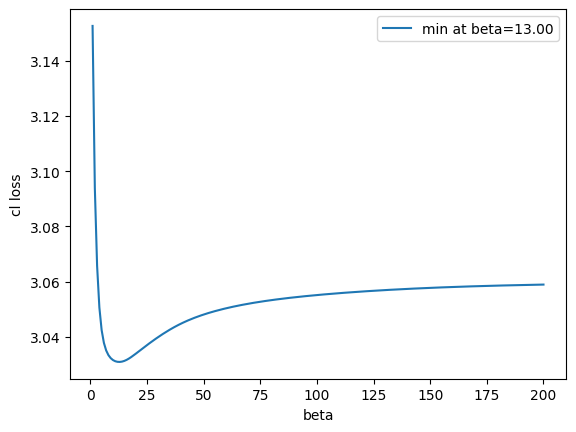

np.float64(13.0)

In [17]:
cl_loss_vs_beta(beta_values=np.linspace(1, 200, 200), 
                batch_size=40, 
                noise_level=0.3, 
                make_plot=True)

# Statistics of optimal beta
Let's find the optimal beta over 100 runs. We should see a pretty narrow, Gaussian-like distribution. Ideally we don't want any optimal beta to be the max beta. 

In [10]:
best_betas = []
for i in range(100):
    best_beta = cl_loss_vs_beta(beta_values=np.linspace(1, 200, 200), 
                batch_size=40, 
                noise_level=0.3, 
                make_plot=False)
    best_betas.append(best_beta)

Text(0, 0.5, 'num of occurances in 100 runs')

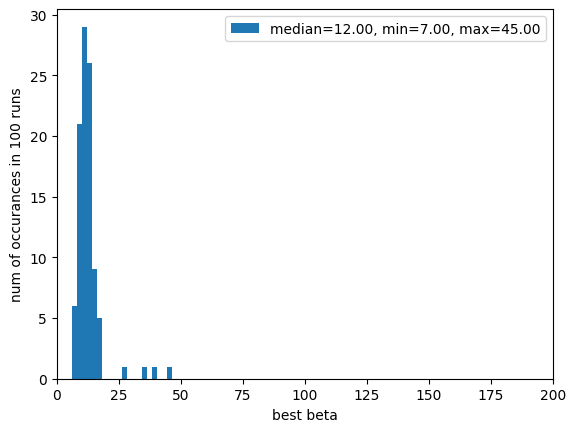

In [11]:
plt.hist(best_betas, bins=np.linspace(0, 200, 100), label=f'median={np.median(best_betas):.2f}, min={np.min(best_betas):.2f}, max={np.max(best_betas):.2f}');
plt.legend()
plt.xlim(0, 200)
plt.xlabel('best beta')
plt.ylabel('num of occurances in 100 runs')